In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt

from copy import deepcopy
from datetime import datetime, timedelta

from configs.base_config import TrainingModuleConfig
from configs.base_config import ModelEvaluatorConfig

from modules.forecasting_module import ForecastingModule
from configs.base_config import ForecastingModuleConfig
from modules.model_evaluator import ModelEvaluator
from modules.training_module import TrainingModule

In [2]:
with open('train_config.json') as f_train, \
    open('test_config.json') as f_test, \
    open('forecast_config.json') as f_forecast:
    default_train_config = json.load(f_train)
    default_test_config = json.load(f_test)
    default_forecast_config = json.load(f_forecast)

In [3]:
def parse_params(parameters, interval='Train1'):
    """
        Flatten the params dictionary to enable logging
    of the parameters.
    
    Assumptions:
        There is a maximum of one level of nesting.
        Ensured using an assert statement for now.
        
    Sample_input:
        {
            'LatentEbyCRatio': {
                '4/7/20': 0.5648337712691847,
                '4/17/20': 1.1427545912005197
            },
            'LatentIbyCRatio': {
                '4/7/20': 0.9610881623714099,
                '4/17/20': 0.6742970940209254
            }
        }
    
    Output:
        {
            'Train1_LatentEbyCRatio_4/7/20': 0.5648337712691847,
            'Train1_LatentEbyCRatio_4/17/20': 1.1427545912005197,
            'Train1_LatentIbyCRatio_4/7/20': 0.9610881623714099,
            'Train1_LatentIbyCRatio_4/17/20': 0.6742970940209254
        }
    """
    param_dict = dict() # The flattened dictionary to return
    for param in parameters:
        if isinstance(parameters[param], dict):
            for key in parameters[param]:
                assert (not isinstance(parameters[param][key], dict))
                
                param_dict[interval + '_' + param + '_'+ key] = parameters[param][key]
        else:
            param_dict[interval + '_' + param] = parameters[param]
    return param_dict

In [4]:
def train_eval(region, region_type, 
               train1_start_date, train1_end_date, 
               train2_start_date, train2_end_date, run_day,
               test_start_date, test_end_date, max_evals = 1000, 
               data_source = None, mlflow_log = True, name_prefix = None):
    """
        #TODO: Need to add hooks to consume data from appropriate source

        Run train and evalation for (basic) SEIR model.
    
    Arguments:
        region, region_type : Region info corresponding to the run
        train1_start_date, train1_end_date : Train1 durations
        train2_start_date, train2_end_date : Train2 durations
        test_start_date, test_end_date, run_day : Test durations
        max_evals : number of search evaluations for SEIR (default: 1000)
        data_source : Data source for picking the region data
        mlflow_log : Experiment logged using MLFlow (default: True)
        name_prefix : In case of non-MLFlow experiment, string prefix to
                      enable easy indexing of experiments

    Note:
        date_format : %-m/%-d/%-y

    Returns: 
        params : Run parameters to be logged
        metrics : Metrics collected from the run 
    
    Output files saved : (name_prefix added in the case of non-MLflow experiments)
        Train1 : train1_output.json (name_prefix + '_train1_output.json')
        Train2 : train2_output.json (name_prefix + '_train2_output.json')
        Test   : test_output.json   (name_prefix + '_test_output.json')
    """
    
    # Save metrics and params for logging
    params = dict()
    metrics = dict()

    params['region'] = region
    params['region_type'] = region_type
    params['train1_start_date'] = train1_start_date
    params['train1_end_date'] = train1_end_date
    params['train2_start_date'] = train2_start_date
    params['train2_end_date'] = train2_end_date
    params['run_day'] = run_day
    params['test_start_date'] = test_start_date
    params['test_end_date'] = test_end_date
    params['data_source'] = data_source
    
    # model parameters
    model_params = dict()
    model_params['region'] = region
    model_params['region_type'] = region_type
    model_params['model_type'] = "SEIR"
    

    train_config = deepcopy(default_train_config)
    train_config['region_name'] = region
    train_config['region_type'] = region_type
    train_config['train_start_date'] = train1_start_date
    train_config['train_end_date'] = train1_end_date
    train_config['search_parameters']['max_evals'] = max_evals
    
    if mlflow_log:
        train_config['output_filepath'] = 'train1_output.json'
    else:
        assert name_prefix is not None
        train_config['output_filepath'] = name_prefix + '_train1_output.json'

    train_module_config = TrainingModuleConfig.parse_obj(train_config)
    trainResults = TrainingModule.from_config(train_module_config)
    
    metrics['Train1MAPE'] = trainResults['train_metric_results'][0]['value']
    metrics['Train1RMLSE'] = trainResults['train_metric_results'][1]['value']
    metrics.update(parse_params(trainResults['best_params'], 'train1'))
    metrics.update(parse_params(trainResults['latent_params'], 'train1')) 
    
    test_config = deepcopy(default_test_config)
    test_config['region_name'] = region
    test_config['region_type'] = region_type
    test_config['test_start_date'] = test_start_date
    test_config['test_end_date'] = test_end_date
    test_config['run_day'] = run_day
    test_config['model_parameters'].update(trainResults['best_params'])    
    test_config['model_parameters'].update(trainResults['latent_params'])  
        
    if mlflow_log:
        test_config['output_filepath'] = 'test_output.json'
    else:
        test_config['output_filepath'] = name_prefix + '_test_output.json'

    test_module_config = ModelEvaluatorConfig.parse_obj(test_config) 
    evalResults = ModelEvaluator.from_config(test_module_config)
    
    metrics['TestMAPE'] = evalResults[0]['value']
    metrics['TestRMLSE'] = evalResults[1]['value']
    
    
    finalTrain_config = deepcopy(default_train_config)
    finalTrain_config['region_name'] = region
    finalTrain_config['region_type'] = region_type
    finalTrain_config['train_start_date'] = train2_start_date
    finalTrain_config['train_end_date'] = train2_end_date
    finalTrain_config['search_parameters']['max_evals'] = max_evals
    
    if mlflow_log:
        finalTrain_config['output_filepath'] = 'train2_output.json'
    else:
        finalTrain_config['output_filepath'] = name_prefix + '_train2_output.json'

    finalTrain_module_config = TrainingModuleConfig.parse_obj(finalTrain_config)
    finalResults = TrainingModule.from_config(finalTrain_module_config)
    
    metrics['Train2MAPE'] = finalResults['train_metric_results'][0]['value']
    metrics['Train2RMLSE'] = finalResults['train_metric_results'][1]['value']
    metrics.update(parse_params(finalResults['best_params'], 'train2'))
    metrics.update(parse_params(finalResults['latent_params'], 'train2'))
        
    model_params['model_parameters'] = dict()
    model_params['model_parameters'].update(finalResults['best_params'])
    model_params['model_parameters'].update(finalResults['latent_params'])
    model_params['model_parameters']['MAPE'] = finalResults['train_metric_results'][0]['value']
    
    return params, metrics, model_params

In [17]:
region = 'mumbai'
region_type = 'district'
train1_start_date = '4/8/20'
train1_end_date = '4/17/20'
train2_start_date = '4/13/20'
train2_end_date = '4/22/20'
test_start_date = '4/18/20'
test_end_date = '4/22/20'
run_day = '4/17/20'

params, metrics, model_params = train_eval(region, region_type, 
                                           train1_start_date, train1_end_date, 
                                           train2_start_date, train2_end_date, run_day,
                                           test_start_date, test_end_date,
                                           max_evals = 3000,
                                           mlflow_log = False,
                                           name_prefix = 'mumbai_sample')

t = 10.90                                               
t = 10.90                                               
t = 10.90                                                                         
t = 10.90                                                                         
t = 10.90                                                                        
t = 10.90                                                                        
t = 10.90                                                                         
t = 10.90                                                                        
t = 10.90                                                                        
t = 10.90                                                                        
t = 10.90                                                                        
t = 10.90                                                                        
t = 10.90                                                      

t = 10.90                                                                         
t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                              

t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                        

t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                        

t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                        

t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                        

t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                        

t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                        

t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                        

t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                        

t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                   

t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                        

t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                        

t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                        

t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                        

t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                        

t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                        

t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                        

t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                        

t = 10.90                                                                            
t = 10.90                                                                            
t = 10.90                                                                            
t = 10.90                                                                            
t = 10.90                                                                            
t = 10.90                                                                            
t = 10.90                                                                            
t = 10.90                                                                            
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                

t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                        

t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                        

t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                        

t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                        

t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                        

t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                        

t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                        

t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                        

t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                        

t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                        

t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                        

t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                        

t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                   

t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                        

t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                        

t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                        

t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                        

t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                        

t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                        

t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                        

t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                        

t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                        

t = 10.90                                                                            
t = 10.90                                                                            
t = 10.90                                                                            
t = 10.90                                                                            
t = 10.90                                                                            
t = 10.90                                                                            
t = 10.90                                                                            
t = 10.90                                                                            
t = 10.90                                                                            
t = 10.90                                                                            
t = 10.90                                                                            
t = 10.90                                             

t = 10.90                                                                            
t = 10.90                                                                            
t = 10.90                                                                            
t = 10.90                                                                            
t = 10.90                                                                            
t = 10.90                                                                            
t = 10.90                                                                            
t = 10.90                                                                            
t = 10.90                                                                            
t = 10.90                                                                            
t = 10.90                                                                            
t = 10.90                                             

t = 10.90                                                                            
t = 10.90                                                                            
t = 10.90                                                                            
t = 10.90                                                                            
t = 10.90                                                                            
t = 10.90                                                                            
t = 10.90                                                                            
t = 10.90                                                                            
t = 10.90                                                                            
t = 10.90                                                                            
t = 10.90                                                                            
t = 10.90                                             

t = 10.90                                                                            
t = 10.90                                                                            
t = 10.90                                                                            
t = 10.90                                                                            
t = 10.90                                                                            
t = 10.90                                                                            
t = 10.90                                                                            
t = 10.90                                                                            
t = 10.90                                                                            
t = 10.90                                                                            
t = 10.90                                                                            
t = 10.90                                             

t = 10.90                                                                            
t = 10.90                                                                            
t = 10.90                                                                            
t = 10.90                                                                            
t = 10.90                                                                            
t = 10.90                                                                            
t = 10.90                                                                            
t = 10.90                                                                            
t = 10.90                                                                            
t = 10.90                                                                            
t = 10.90                                                                            
t = 10.90                                             

t = 10.90                                                                            
t = 10.90                                                                            
t = 10.90                                                                            
t = 10.90                                                                            
t = 10.90                                                                            
t = 10.90                                                                            
t = 10.90                                                                            
t = 10.90                                                                            
t = 10.90                                                                            
t = 10.90                                                                            
t = 10.90                                                                            
t = 10.90                                             

t = 10.90                                                                            
t = 10.90                                                                            
t = 10.90                                                                            
t = 10.90                                                                            
t = 10.90                                                                            
t = 10.90                                                                            
t = 10.90                                                                            
t = 10.90                                                                            
t = 10.90                                                                            
t = 10.90                                                                            
t = 10.90                                                                            
t = 10.90                                             

t = 10.90                                                                            
t = 10.90                                                                            
t = 10.90                                                                            
t = 10.90                                                                            
t = 10.90                                                                            
t = 10.90                                                                            
t = 10.90                                                                            
t = 10.90                                                                            
t = 10.90                                                                            
t = 10.90                                                                            
t = 10.90                                                                            
t = 10.90                                             

t = 10.90                                                                            
t = 10.90                                                                            
t = 10.90                                                                            
t = 10.90                                                                            
t = 10.90                                                                            
t = 10.90                                                                            
t = 10.90                                                                            
t = 10.90                                                                            
t = 10.90                                                                            
t = 10.90                                                                            
t = 10.90                                                                            
t = 10.90                                             

t = 10.90                                                                            
t = 10.90                                                                            
t = 10.90                                                                            
t = 10.90                                                                            
t = 10.90                                                                            
t = 10.90                                                                            
t = 10.90                                                                            
t = 10.90                                                                            
t = 10.90                                                                            
t = 10.90                                                                            
t = 10.90                                                                            
t = 10.90                                             

t = 10.90                                                                            
t = 10.90                                                                            
t = 10.90                                                                            
t = 10.90                                                                            
t = 10.90                                                                            
t = 10.90                                                                            
t = 10.90                                                                            
t = 10.90                                                                            
t = 10.90                                                                            
t = 10.90                                                                            
t = 10.90                                                                            
t = 10.90                                             

t = 10.90                                                                            
t = 10.90                                                                            
t = 10.90                                                                            
t = 10.90                                                                            
t = 10.90                                                                            
t = 10.90                                                                            
t = 10.90                                                                            
t = 10.90                                                                            
t = 10.90                                                                            
t = 10.90                                                                            
t = 10.90                                                                            
t = 10.90                                             

t = 10.90                                                                            
t = 10.90                                                                            
t = 10.90                                                                            
t = 10.90                                                                            
t = 10.90                                                                            
t = 10.90                                                                            
t = 10.90                                                                            
t = 10.90                                                                            
t = 10.90                                                                            
t = 10.90                                                                            
t = 10.90                                                                            
t = 10.90                                             

t = 10.90                                                                            
t = 10.90                                                                            
t = 10.90                                                                            
t = 10.90                                                                            
t = 10.90                                                                            
t = 10.90                                                                            
t = 10.90                                                                            
t = 10.90                                                                            
t = 10.90                                                                            
t = 10.90                                                                            
t = 10.90                                                                            
t = 10.90                                             

t = 10.90                                                                            
t = 10.90                                                                            
t = 10.90                                                                            
t = 10.90                                                                            
t = 10.90                                                                            
t = 10.90                                                                            
t = 10.90                                                                            
t = 10.90                                                                            
t = 10.90                                                                            
t = 10.90                                                                            
t = 10.90                                                                            
t = 10.90                                             

t = 10.90                                                                            
t = 10.90                                                                            
t = 10.90                                                                            
t = 10.90                                                                            
t = 10.90                                                                            
t = 10.90                                                                            
t = 10.90                                                                            
t = 10.90                                                                            
t = 10.90                                                                            
t = 10.90                                                                            
t = 10.90                                                                            
t = 10.90                                             

t = 10.90                                                                            
t = 10.90                                                                            
t = 10.90                                                                            
t = 10.90                                                                            
t = 10.90                                                                            
t = 10.90                                                                            
t = 10.90                                                                            
t = 10.90                                                                            
t = 10.90                                                                            
t = 10.90                                                                            
t = 10.90                                                                            
t = 10.90                                             

t = 10.90                                                                            
t = 10.90                                                                            
t = 10.90                                                                            
t = 10.90                                                                            
t = 10.90                                                                            
t = 10.90                                                                            
t = 10.90                                                                            
t = 10.90                                                                            
t = 10.90                                                                            
t = 10.90                                                                            
t = 10.90                                                                            
t = 10.90                                             

t = 10.90                                                                            
t = 10.90                                                                            
t = 10.90                                                                            
t = 10.90                                                                            
t = 10.90                                                                            
t = 10.90                                                                            
t = 10.90                                                                            
t = 10.90                                                                            
t = 10.90                                                                            
t = 10.90                                                                            
t = 10.90                                                                            
t = 10.90                                             

t = 10.90                                                                            
t = 10.90                                                                            
t = 10.90                                                                            
t = 10.90                                                                            
t = 10.90                                                                            
t = 10.90                                                                            
t = 10.90                                                                            
t = 10.90                                                                            
t = 10.90                                                                            
t = 10.90                                                                            
t = 10.90                                                                            
t = 10.90                                             

t = 10.90                                                                            
t = 10.90                                                                            
t = 10.90                                                                            
t = 10.90                                                                            
t = 10.90                                                                            
t = 10.90                                                                            
t = 10.90                                                                            
t = 10.90                                                                            
t = 10.90                                                                            
t = 10.90                                                                            
t = 10.90                                                                            
t = 10.90                                             

In [18]:
params

{'region': 'mumbai',
 'region_type': 'district',
 'train1_start_date': '4/8/20',
 'train1_end_date': '4/17/20',
 'train2_start_date': '4/13/20',
 'train2_end_date': '4/22/20',
 'run_day': '4/17/20',
 'test_start_date': '4/18/20',
 'test_end_date': '4/22/20',
 'data_source': None}

In [19]:
metrics

{'Train1MAPE': 2.513164449219763,
 'Train1RMLSE': 0.03449813254497608,
 'train1_EbyCRatio': 0.5072652686227713,
 'train1_IbyCRatio': 0.8869314390395954,
 'train1_infectious_period': 1.7191073210238612,
 'train1_r0': 3.643109334886052,
 'train1_LatentEbyCRatio_4/7/20': 0.5072652686227713,
 'train1_LatentEbyCRatio_4/17/20': 0.4529681001746445,
 'train1_LatentIbyCRatio_4/7/20': 0.8869314390395954,
 'train1_LatentIbyCRatio_4/17/20': 0.14676500154376163,
 'TestMAPE': 10.558752165988865,
 'TestRMLSE': 0.11397219809304418,
 'Train2MAPE': 3.0557864655519063,
 'Train2RMLSE': 0.03480134859127813,
 'train2_EbyCRatio': 0.627394229678556,
 'train2_IbyCRatio': 0.9407222722761999,
 'train2_infectious_period': 1.0361856333902497,
 'train2_r0': 1.7337892365820329,
 'train2_LatentEbyCRatio_4/12/20': 0.627394229678556,
 'train2_LatentEbyCRatio_4/22/20': 0.13981576368119505,
 'train2_LatentIbyCRatio_4/12/20': 0.9407222722761999,
 'train2_LatentIbyCRatio_4/22/20': 0.033033207302667705}

In [20]:
model_params

{'region': 'mumbai',
 'region_type': 'district',
 'model_type': 'SEIR',
 'model_parameters': {'EbyCRatio': 0.627394229678556,
  'IbyCRatio': 0.9407222722761999,
  'infectious_period': 1.0361856333902497,
  'r0': 1.7337892365820329,
  'LatentEbyCRatio': {'4/12/20': 0.627394229678556,
   '4/22/20': 0.13981576368119505},
  'LatentIbyCRatio': {'4/12/20': 0.9407222722761999,
   '4/22/20': 0.033033207302667705},
  'MAPE': 3.0557864655519063}}

In [21]:
model_params['model_parameters']['incubation_period'] = 5

In [22]:
model_params

{'region': 'mumbai',
 'region_type': 'district',
 'model_type': 'SEIR',
 'model_parameters': {'EbyCRatio': 0.627394229678556,
  'IbyCRatio': 0.9407222722761999,
  'infectious_period': 1.0361856333902497,
  'r0': 1.7337892365820329,
  'LatentEbyCRatio': {'4/12/20': 0.627394229678556,
   '4/22/20': 0.13981576368119505},
  'LatentIbyCRatio': {'4/12/20': 0.9407222722761999,
   '4/22/20': 0.033033207302667705},
  'MAPE': 3.0557864655519063,
  'incubation_period': 5}}

In [15]:
def plot(model_params, run_day, forecast_start_date, forecast_end_date, plot_name = 'default.png'):
    evalConfig = ForecastingModuleConfig.parse_obj(default_forecast_config)
    evalConfig.region_name = model_params['region']
    evalConfig.region_type = model_params['region_type']
    evalConfig.model_parameters = model_params['model_parameters']

    evalConfig.run_day = run_day
    evalConfig.forecast_start_date = forecast_start_date
    evalConfig.forecast_end_date = forecast_end_date
    
    pdjson1 = ForecastingModule.from_config(evalConfig)
    pdjson = pd.read_json(pdjson1)
    pdjson = pdjson.set_index('prediction_type')
    pdjson = pdjson.transpose()
    pdjson = pdjson.reset_index()
    pdjson = pdjson[4:]

    fig, ax = plt.subplots(figsize=(15, 5))
    fig.suptitle(model_params['region'])
    ax.plot(pdjson['index'], pdjson['actual_confirmed'], color='blue', label="actual_confirmed")
    ax.plot(pdjson['index'], pdjson['confirmed_mean'], color='orange', label="predicted_confirmed")
    ax.set_ylim(ymin=0)
    ax.legend()
    
    plt.savefig(plot_name)

t = 10.90


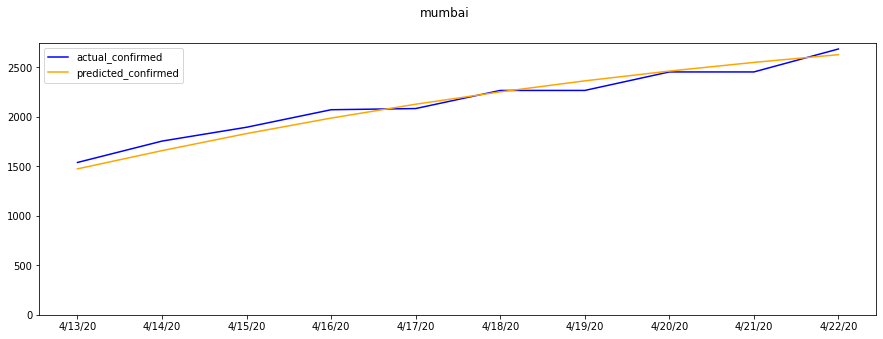

In [23]:
run_day = '4/12/20'
forecast_start_date = '4/13/20'
forecast_end_date = '4/22/20'
plot(model_params, run_day, forecast_start_date, forecast_end_date)

In [24]:
def train_eval_plot(region, region_type, 
                    train1_start_date, train1_end_date, 
                    train2_start_date, train2_end_date,
                    test_run_day, test_start_date, test_end_date, 
                    forecast_run_day, forecast_start_date, forecast_end_date,
                    max_evals = 1000, 
                    data_source = None, mlflow_log = True, name_prefix = None,
                    plot_name = 'default.png'):
    params, metrics, model_params = train_eval(region, region_type, 
                                               train1_start_date, train1_end_date, 
                                               train2_start_date, train2_end_date, 
                                               test_run_day, test_start_date, test_end_date, 
                                               max_evals, data_source, 
                                               mlflow_log, name_prefix)
    model_params['model_parameters']['incubation_period'] = 5
    plot(model_params, forecast_run_day, forecast_start_date, forecast_end_date)

t = 10.90                                               
t = 10.90                                               
t = 10.90                                                                         
t = 10.90                                                                         
t = 10.90                                                                        
t = 10.90                                                                        
t = 10.90                                                                        
t = 10.90                                                                        
t = 10.90                                                                        
t = 10.90                                                                        
t = 10.90                                                                        
t = 10.90                                                                         
t = 10.90                                                      

t = 10.90                                                                        
t = 10.90                                                                        
t = 10.90                                                                         
t = 10.90                                                                         
t = 10.90                                                                         
t = 10.90                                                                         
t = 10.90                                                                         
t = 10.90                                                                         
t = 10.90                                                                         
t = 10.90                                                                         
t = 10.90                                                                         
t = 10.90                                                                         
t = 10

t = 10.90                                                                         
t = 10.90                                                                         
t = 10.90                                                                         
t = 10.90                                                                         
t = 10.90                                                                         
t = 10.90                                                                         
t = 10.90                                                                         
t = 10.90                                                                         
t = 10.90                                                                         
t = 10.90                                                                         
t = 10.90                                                                         
t = 10.90                                                                         
t = 

t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                        

t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                        

t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                        

t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                        

t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                        

t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                        

t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                        

t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                                           
t = 10.90                                                        

t = 10.90                                                                         
t = 10.90                                                                         
t = 10.90                                                                         
t = 10.90                                                                         
t = 10.90                                                                         
t = 10.90                                                                         
t = 10.90                                                                         
t = 10.90                                                                         
t = 10.90                                                                         
t = 10.90                                                                         
t = 10.90                                                                         
t = 10.90                                                                         
t = 

t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                   

t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                   

t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                   

t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                   

t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                   

t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                   

t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                   

t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                   

t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                          
t = 10.90                                                                   

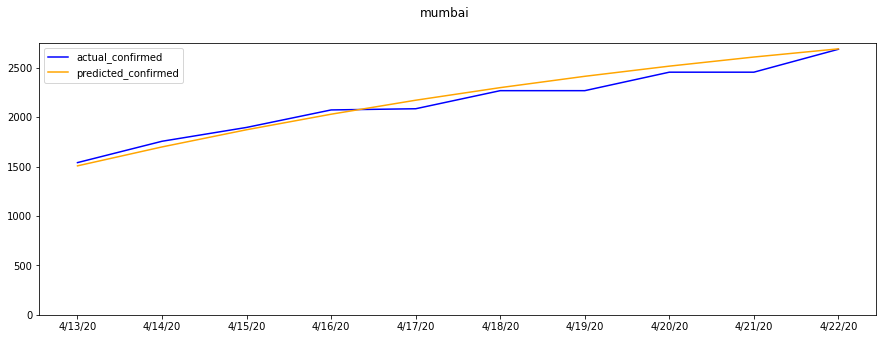

In [25]:
region = 'mumbai'
region_type = 'district'
train1_start_date = '4/8/20'
train1_end_date = '4/17/20'
train2_start_date = '4/13/20'
train2_end_date = '4/22/20'
test_start_date = '4/18/20'
test_end_date = '4/22/20'
test_run_day = '4/17/20'
forecast_run_day = '4/12/20'
forecast_start_date = '4/13/20'
forecast_end_date = '4/22/20'
name_prefix = 'mumbai_sample'

train_eval_plot(region, region_type, 
                train1_start_date, train1_end_date, 
                train2_start_date, train2_end_date,
                test_run_day, test_start_date, test_end_date, 
                forecast_run_day, forecast_start_date, forecast_end_date,
                max_evals = 1000, 
                mlflow_log = False, name_prefix = name_prefix,
                plot_name = 'default.png')